In [129]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
 
import torchvision  # 图片、视频处理
from torchvision import datasets, transforms
# from transforms import ToTensor
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available else 'cpu'
# device='cpu'
torch.__version__, torchvision.__version__, device


('2.0.1', '0.15.2', 'cuda')

In [130]:
torch.cuda.caching_allocator_delete


<function torch.cuda.memory.caching_allocator_delete(mem_ptr)>

In [131]:
torch.cuda.empty_cache()  # 释放显存


In [132]:
print('Memory Allocated', torch.cuda.memory_allocated() )

Memory Allocated 27110400


ToTensor: 
- 1、输入转为Tensor，
- 2、图片格式为 channel, height, width; 
- 3、像素取值范围规范到0/1

torch.utils.data.DataLoader, 作用：
- 乱序， shuffle 默认为 True
- 将数据采样为小批次， batch_size. batch太小会导致loss的剧烈震荡，太大则内存放不下，也会跨度过大，失去准确性；
- num_workers, 子进程设置，更多进程参与
- 设置批次处理函数 collate_fn, 用在文本等


In [133]:
transformation = transforms.Compose([
    transforms.ToTensor(),
])

In [134]:
train_ds = torchvision.datasets.MNIST('data', 
                                      train=True, 
                                      download=True, 
                                      transform=ToTensor())
test_ds = torchvision.datasets.MNIST('data', 
                                     train=False , 
                                     download=True, 
                                     transform=ToTensor())
# test_ds = test_ds.to(device)

In [135]:
batch_size = 64
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)  # batch_size开始为64,可能是最佳，或128
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [136]:
imgs, labels = next(iter(train_dl))   # train dataloder 可以分解出X和Ydata
imgs.shape, labels.shape   # 1: 黑白图片， 28x28的图片分辨率， 64张


(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [137]:
# imgs, labels

In [138]:
""" imgs, labels 内容显示 """
# plt.figure(figsize=(10, 1))
# for i, img in enumerate( imgs[:8] ): #取前10张图片   
#     npimg = img.numpy()         
#     npimg = np.squeeze( npimg )  # 从1x28x28 变为 28x28， 1维的被 squeeze 删除
#     plt.subplot(1, 10, i+1)
#     plt.imshow(npimg)
#     plt.axis('off')
# print( imgs.shape, img.shape)       # img 被切片，降维了。
# print( labels[:8] )

' imgs, labels 内容显示 '

In [139]:
""" 测试卷积函数 """
# input = torch.randint(2,[2,3,4])
# input = torch.randn(5)
# input
# input, torch.relu(input)

# input,torch.sigmoid( input )
# input,torch.tanh( input )
# input,nn.LeakyReLU( input )

' 测试卷积函数 '

上面是数据准备和模式测试， 
以下正式开始设计：

In [140]:
# 多层感知器模型， 添加1个隐藏层，
class Model( nn.Module ):   # 从nn类初始化
    def __init__(self):
        super().__init__()  # 初始化父类属性
        self.conv1 = nn.Conv2d(1, 6, 5)         # 专门针对2d图片的卷积， 1个输入channel(黑白)， 6个输出（自定义）； 5:5x5的kernel size; 其余用的default,中级再调试
        self.pool = nn.MaxPool2d((2,2))        # 用MaxPool的池化方式，2x2 (输入的28x28 -> 14x14 )
        self.conv2 = nn.Conv2d(6, 16, 5)        # 6输入channel( conv1 = 6 )， 自定义16个输出； 5:5x5的kernel size; 
        self.linear_1 = nn.Linear(16*4*4, 256)  # conv2的16个output_channel, 5x5d的kernel size； 256自定义
        self.linear_2 = nn.Linear(256, 10)  
    def forward(self, input):
        x = F.relu( self.conv1(input))
        x = self.pool(x)    
        x = F.relu( self.conv2(x))
        x = self.pool(x)
        # print(x.size())  output: [64,16,4,4]
        
        x = x.view(x.size(0), -1)       # 上一课： x = input.view(-1, 1*28*28)
        x = F.relu(self.linear_1(x))
        x = self.linear_2(x)            
        return x
    

In [141]:
# model = Model().to('cpu')  
model = Model().to(device)  
# model = Model().to('cpu')  

In [142]:
# imgs = imgs.to(device)
# # imgs = imgs.to('cpu')
# model(imgs)

In [143]:
"""
- target： 0,1,2,3.。。 并不是一个独热编码的形式？
- input： logits
- output：？
"""
loss_fn = nn.CrossEntropyLoss()  
# input = torch.randn(5)
# input, np.argmax(input)

In [144]:
"""
优化： 根据计算得到的损失，调整模型参数， 降低损失的过程；
- Adam 优化器
- SGD：优化model的参数、以及lr
"""
opt = torch.optim.SGD(model.parameters(), lr=0.001)

In [145]:
"""
训练循环：计算准确率correect， 以及每个批次的平均loss
"""
def train(dl, model, loss_fn, optimizer):
    size = len( dl.dataset )    # 数据多少？
    num_batches = len(dl)       # 返回训练批次
    train_loss, correct = 0, 0 # 每个批次累计的loss之和， 正确的样本数累计
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)     # 按照损失函数，计算损失
        optimizer.zero_grad()       # 清零后计算新的loop的梯度；
        loss.backward()             # 按照loss，反向计算梯度；
        optimizer.step()
        with torch.no_grad():
            # pred是2维，0维是batch数，1维才是0-9的logits输出；boll转换为float32，累计;item转换到python
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()  
            train_loss += loss.item()
    correct /= size
    train_loss /= num_batches      # losss是以每个批次计算，correct是以个数计算；所以分母不同；
    return correct, train_loss

In [146]:
# 测试函数: 计算准确率correect， 以及每个批次的平均loss
def test(test_dl, model, loss_fn):
    size = len( test_dl.dataset )    # 数据多少？
    num_batches = len(test_dl)       # 返回训练批次
    test_loss, correct = 0, 0 # 每个批次累计的loss之和， 正确的样本数累计
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)     # 按照损失函数，计算损失
            test_loss += loss.item()
            # pred是2维，0维是batch数，1维才是0-9的logits输出；boll转换为float32，累计;item转换到python
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()  
        correct /= size
        test_loss /= num_batches      # losss是以每个批次计算，correct是以个数计算；所以分母不同；
        return correct, test_loss

In [147]:
""" 
    训练 N 个 epoch， 记录每个epoch的train和test的损失、准确率。 
"""
# batch_size 非常关键：4096不准确； 64很准确。16也比较差。 ！！！
def fit(epochs, train_dl, test_dl, model, loss_fn, opt ):
    # epochs = 20
    train_loss, train_acc = [], []
    test_loss,  test_acc  = [], []

    for epoch in range( epochs ):
        epoch_acc, epoch_loss = train( train_dl, model, loss_fn, opt)
        epoch_test_acc, epoch_test_loss = test( test_dl, model, loss_fn)
        train_acc.append(epoch_acc)
        train_loss.append(epoch_loss)
        test_acc.append(epoch_test_acc)
        test_loss.append(epoch_test_loss)  # 记录、图表化后，观察是否会过拟合等问题
        
        template = ("epoch:{:2d}, train_Loss:{:.5f}, train_acc:{:.2f}, test_Loss:{:.5f}, test_acc:{:.2f}, ")
        print(template.format( epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    print('Done')
    return train_loss, train_acc, test_loss, test_acc


In [148]:
epochs = 100
batch_size = 16
# batch_size = 64   
# batch_size = 128
# batch_size = 256
# batch_size = 1024
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)  # batch_size开始为64
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)
train_loss, train_acc, test_loss, test_acc = fit(epochs,train_dl, test_dl, model, loss_fn, opt)


epoch: 0, train_Loss:1.87831, train_acc:50.19, test_Loss:0.72557, test_acc:80.96, 
epoch: 1, train_Loss:0.49137, train_acc:85.87, test_Loss:0.36269, test_acc:89.23, 
epoch: 2, train_Loss:0.33620, train_acc:89.97, test_Loss:0.27503, test_acc:91.63, 
epoch: 3, train_Loss:0.27203, train_acc:91.74, test_Loss:0.22928, test_acc:93.14, 
epoch: 4, train_Loss:0.22946, train_acc:93.08, test_Loss:0.19870, test_acc:94.20, 
epoch: 5, train_Loss:0.19777, train_acc:94.06, test_Loss:0.16751, test_acc:95.14, 
epoch: 6, train_Loss:0.17256, train_acc:94.88, test_Loss:0.15163, test_acc:95.43, 
epoch: 7, train_Loss:0.15398, train_acc:95.38, test_Loss:0.13169, test_acc:96.05, 
epoch: 8, train_Loss:0.13864, train_acc:95.88, test_Loss:0.12578, test_acc:96.04, 
epoch: 9, train_Loss:0.12700, train_acc:96.23, test_Loss:0.10882, test_acc:96.76, 
epoch:10, train_Loss:0.11665, train_acc:96.48, test_Loss:0.10887, test_acc:96.76, 
epoch:11, train_Loss:0.10850, train_acc:96.73, test_Loss:0.09591, test_acc:97.11, 
epoc

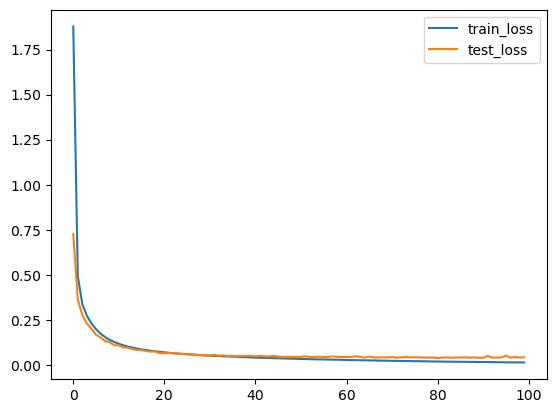

In [149]:
plt.plot( range(epochs), train_loss, label='train_loss')
plt.plot( range(epochs), test_loss, label='test_loss')
plt.legend()
# train_acc

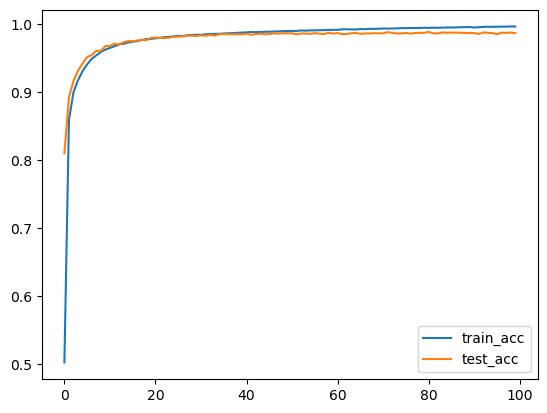

In [150]:
plt.plot( range(epochs), train_acc, label='train_acc')
plt.plot( range(epochs), test_acc, label='test_acc')
plt.legend()